# Section 1: Import the dependencies

In [1]:
import numpy as np
import pandas as pd
import kagglehub
import os
import tensorflow as tf
from tqdm import tqdm
import pickle
import string
from textwrap import wrap

# Keras imports
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, concatenate, Reshape
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# NLTK import for BLEU score calculation
from nltk.translate.bleu_score import corpus_bleu # <-- NEW

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Section 2: Download and Load Dataset

In [2]:
try:
    path = kagglehub.dataset_download("adityajn105/flickr8k")
    IMAGE_PATH = os.path.join(path, "Images")
    CAPTIONS_PATH = os.path.join(path, "captions.txt")
except Exception as e:
    print(f"KaggleHub download failed, falling back to standard Kaggle input path. Error: {e}")
    IMAGE_PATH = '/kaggle/input/flickr8k/Images'
    CAPTIONS_PATH = "/kaggle/input/flickr8k/captions.txt"


data = pd.read_csv(CAPTIONS_PATH)
print("Dataset loaded successfully.")
print(data.head())

Using Colab cache for faster access to the 'flickr8k' dataset.
Dataset loaded successfully.
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


# Section 3: Visualization

In [3]:
def read_image(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = read_image(os.path.join(IMAGE_PATH, temp_df.image[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# Section 4: Caption Text Preprocessing Steps

In [4]:
def clean_caption(text):
    # Create a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.split()
    # Convert to lower case
    text = [word.lower() for word in text]
    # Remove punctuation
    text = [word.translate(table) for word in text]
    # Remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    # Remove single-character tokens
    text = [word for word in text if len(word) > 1]
    # Join back to a string and add sequence tokens
    return 'startseq ' + ' '.join(text) + ' endseq'

data['caption'] = data['caption'].apply(clean_caption)
print("Text preprocessing complete.")
print(data['caption'].head())

Text preprocessing complete.
0    startseq child in pink dress is climbing up se...
1      startseq girl going into wooden building endseq
2    startseq little girl climbing into wooden play...
3    startseq little girl climbing the stairs to he...
4    startseq little girl in pink dress going into ...
Name: caption, dtype: object


# Section 5: Tokenization and Encoded Representation

In [5]:
captions = data['caption'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

print(f"Vocabulary Size: {vocab_size}")
print(f"Max Caption Length: {max_length}")

# Create a train/validation split
images = data['image'].unique().tolist()
n_images = len(images)
split_index = round(0.85 * n_images)
train_images = set(images[:split_index])
val_images = set(images[split_index:])

train_df = data[data['image'].isin(train_images)]
val_df = data[data['image'].isin(val_images)]

# This maps each validation image to its list of 5 captions
val_captions_dict = {}
for img, cap in zip(val_df['image'], val_df['caption']):
    if img not in val_captions_dict:
        val_captions_dict[img] = []
    val_captions_dict[img].append(cap)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Vocabulary Size: 8766
Max Caption Length: 34
Training samples: 34385
Validation samples: 6070


# Section 6: Image Feature Extraction

In [6]:
def extract_features(image_names, image_path_base, model):
    features = {}
    img_size = 224
    for image_name in tqdm(image_names, desc="Extracting Features"):
        img_path = os.path.join(image_path_base, image_name)
        img = load_img(img_path, target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        feature = model.predict(img, verbose=0)
        features[image_name] = feature
    return features

# Using DenseNet201 pre-trained model for feature extraction
base_model = DenseNet201()
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output, name="feature_extractor")

all_image_names = data['image'].unique().tolist()
all_features = extract_features(all_image_names, IMAGE_PATH, feature_extractor)

# Split features into training and validation sets
train_features = {name: all_features[name] for name in train_images}
val_features = {name: all_features[name] for name in val_images}

Extracting Features: 100%|██████████| 8091/8091 [15:15<00:00,  8.84it/s]


# Section 7: Data Generation

In [7]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, features, tokenizer, max_length, vocab_size, batch_size, shuffle=True):
        self.df = df.copy()
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        # Iterate directly over rows, which is more efficient
        for _, row in batch.iterrows():
            feature = self.features[row['image']][0]
            caption = row['caption']
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

# Create data generators
train_generator = CustomDataGenerator(train_df, train_features, tokenizer, max_length, vocab_size, batch_size=64)
validation_generator = CustomDataGenerator(val_df, val_features, tokenizer, max_length, vocab_size, batch_size=64)

# Section 8: Model

In [8]:
def define_captioning_model(vocab_size, max_length, feature_shape=1920):
    # Image feature extractor model
    input1 = Input(shape=(feature_shape,))
    img_features1 = Dropout(0.5)(input1)
    img_features2 = Dense(256, activation='relu')(img_features1)

    # Sequence model
    input2 = Input(shape=(max_length,))
    seq_features1 = Embedding(vocab_size, 256, mask_zero=False)(input2)
    seq_features2 = Dropout(0.5)(seq_features1)
    seq_features3 = LSTM(256)(seq_features2)

    # Decoder (merging both models)
    decoder1 = add([img_features2, seq_features3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    output = Dense(vocab_size, activation='softmax')(decoder2)

    # Create the final model
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

caption_model = define_captioning_model(vocab_size, max_length)
print(caption_model.summary())

# Generate and save a plot of the model architecture
plot_model(caption_model, to_file='model_architecture.png', show_shapes=True)
print("Model architecture saved to model_architecture.png")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,096 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1920)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8766)      │  2,252,862 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,579,838 (21.29 MB)

 Trainable params: 5,579,838 (21.29 MB)

 Non-trainable params: 0 (0.00 B)

None
Model architecture saved to model_architecture.png


# Section 9: Model Training

In [9]:
MODEL_NAME = "image_caption_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(filepath=MODEL_NAME, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# Set a smaller number of epochs for a quick run, increase for better performance
EPOCHS = 20

history = caption_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 5.3844
Epoch 1: val_loss improved from inf to 3.96528, saving model to image_caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 135ms/step - loss: 5.3831 - val_loss: 3.9653 - learning_rate: 0.0010
Epoch 2/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 3.7852
Epoch 2: val_loss improved from 3.96528 to 3.69240, saving model to image_caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 67s 126ms/step - loss: 3.7851 - val_loss: 3.6924 - learning_rate: 0.0010
Epoch 3/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 3.4013
Epoch 3: val_loss improved from 3.69240 to 3.58612, saving model to image_caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 68s 127ms/step - loss: 3.4013 - val_loss: 3.5861 - learning_rate: 0.0010
Epoch 4/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 3.1688
Epoch 4: val_loss improved from 3.58612 to 3.55298, saving model to image_caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 69s 128ms/step - 

# Section 10: Learning Curve

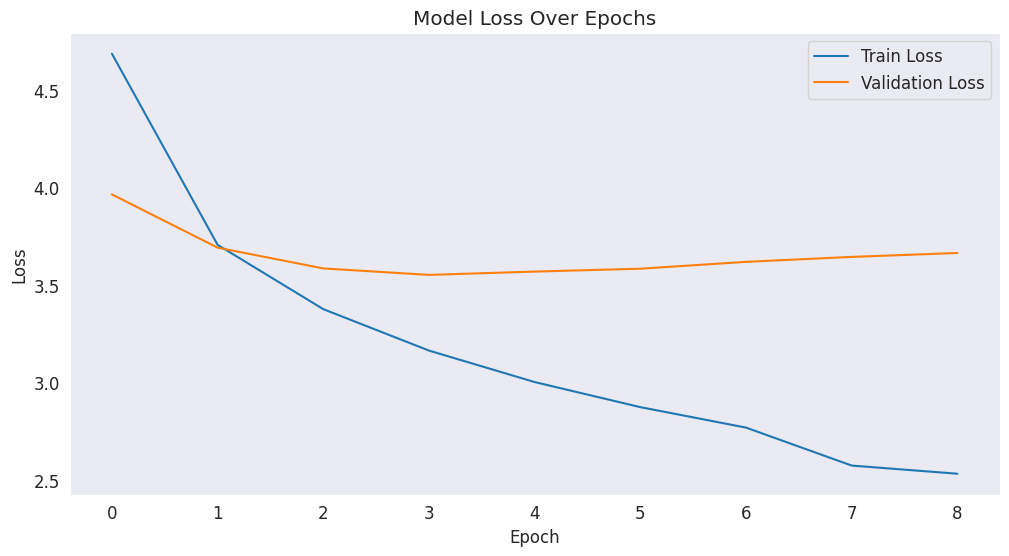

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Section 11: Quantitative Evaluation with BLEU Score

In [11]:
def generate_caption(model, tokenizer, photo_feature, max_length):
    # Generates a caption for a single image feature
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace("startseq", "").replace("endseq", "").strip()

def evaluate_model_bleu(model, tokenizer, features_dict, captions_dict, max_length):
    # Evaluates the model on the validation set using BLEU score
    actual, predicted = [], []
    for image_name, captions_list in tqdm(captions_dict.items(), desc="Evaluating BLEU Score"):
        # Get the image feature
        photo_feature = features_dict[image_name]
        # Generate a caption
        generated_caption = generate_caption(model, tokenizer, photo_feature, max_length)
        # Get the real captions (and clean them for BLEU calculation)
        references = [cap.replace("startseq", "").replace("endseq", "").split() for cap in captions_list]
        actual.append(references)
        predicted.append(generated_caption.split())

    # Calculate BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    print("\n--- BLEU Score Results ---")
    print(f"BLEU-1: {bleu1*100:.2f}")
    print(f"BLEU-2: {bleu2*100:.2f}")
    print(f"BLEU-3: {bleu3*100:.2f}")
    print(f"BLEU-4: {bleu4*100:.2f}")
    print("--------------------------")

# Load the best saved model and run evaluation
best_model = load_model(MODEL_NAME)
evaluate_model_bleu(best_model, tokenizer, val_features, val_captions_dict, max_length)

Evaluating BLEU Score: 100%|██████████| 1214/1214 [14:26<00:00,  1.40it/s]



--- BLEU Score Results ---
BLEU-1: 50.64
BLEU-2: 31.06
BLEU-3: 18.96
BLEU-4: 10.89
--------------------------


# Section 12: Qualitative Results - Caption Generation on New Images

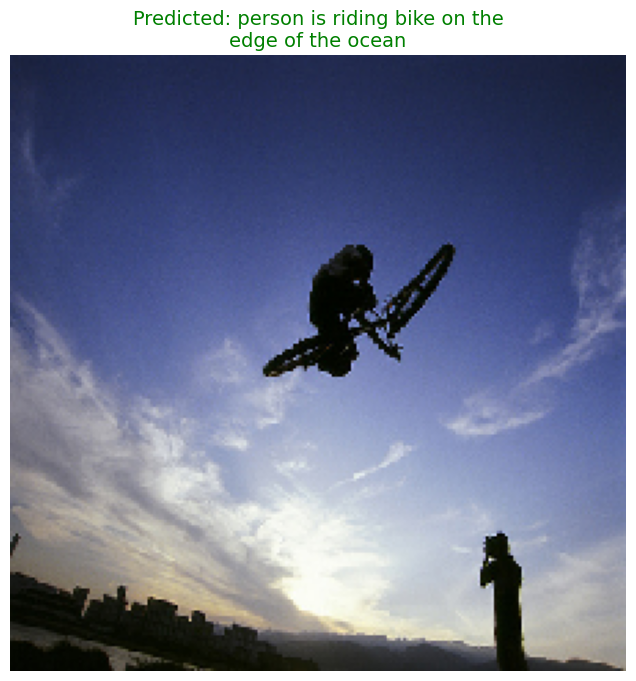

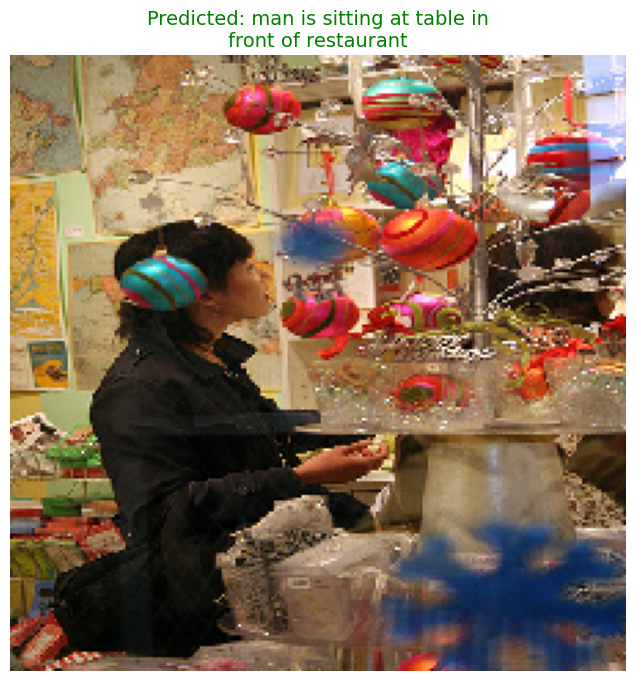

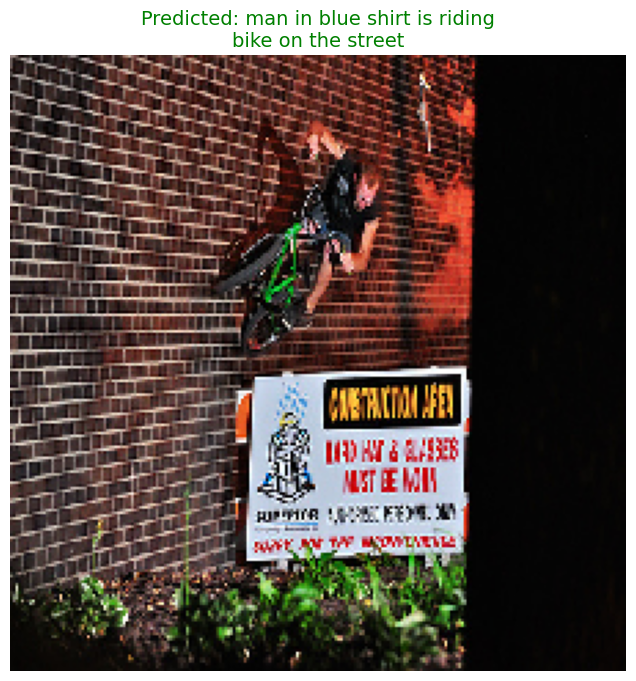

In [12]:
def display_prediction(image_path, model, tokenizer, feature_extractor, max_length):
    # Displays an image with its predicted caption
    # Extract features
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    photo_feature = feature_extractor.predict(img_array, verbose=0)

    # Generate caption
    caption = generate_caption(model, tokenizer, photo_feature, max_length)

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title("\n".join(wrap(f"Predicted: {caption}", 40)), fontsize=14, color='green')
    plt.show()

# Save the necessary components for easy inference later
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Example usage:
# Pick some random validation images to see the results
val_image_names = list(val_images)
display_prediction(os.path.join(IMAGE_PATH, val_image_names[10]), best_model, tokenizer, feature_extractor, max_length)
display_prediction(os.path.join(IMAGE_PATH, val_image_names[25]), best_model, tokenizer, feature_extractor, max_length)
display_prediction(os.path.join(IMAGE_PATH, val_image_names[50]), best_model, tokenizer, feature_extractor, max_length)